In [1]:
#pip install scipy
#pip install spacy
#python -m spacy download en_core_web_sm
#pip install gensim
#pip install pyLDAvis
#pip install networkx

In [2]:
import pandas as pd 
import re 
import string 
import nltk

# Uncomment the next two lines if you miss these packages
#nltk.download('stopwords')
#nltk.download('punkt')

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import nltk.corpus  
from nltk import bigrams
from nltk.text import Text 
import itertools
import collections
import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.decomposition import LatentDirichletAllocation
from scipy.cluster.hierarchy import ward, dendrogram, single,complete,average,weighted,centroid,median
from scipy.spatial.distance import pdist
import spacy
import math
import numpy as np
import pyLDAvis.gensim
import pickle 
import pyLDAvis
import gensim
from gensim.utils import simple_preprocess
import gensim.corpora as corpora
from gensim.models import CoherenceModel
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
# set PYTHONHASHSEED to have Gensim Reproducability
%env PYTHONHASHSEED=0

env: PYTHONHASHSEED=0


In [3]:
ReyPosts = pd.read_csv('WheresRey.csv', encoding="ISO-8859-1")
# to display the first few rows
ReyPosts.head()

,Week,Posts,PostsInWeek
0,1,Target exclusively released a StarWars toy s...,4
1,1,Hasbro Why do you always leave the girl charac...,4
2,1,Oh look they even included some women IN THE B...,4
3,1,osakadaioh1 damn serious. Disney sexist market...,4
4,2,TheMarySue Who is missing from this picture? ...,314


In [4]:
def ReyPreprocessing(text): 
    # get lowercase
    text = text.lower()
    # remove numbers    # remove numbers

    text = re.sub(r'\d+', '', text)
    # remove urls
    text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text)
    # remove punctuation
    text = text.translate(text.maketrans('', '', string.punctuation))
    # strip whitespace
    text = text.strip()
    # remove stop words
    stop_words = stopwords.words('english')
    newStopWords = ['html','yet']
    stop_words.extend(newStopWords)
    stop_words = set(stop_words)
    tokens = word_tokenize(text)
    words = [w for w in tokens if not w in stop_words]
    text = " ".join(w for w in words)
    text = text.replace('theforceawakens', 'the force awakens')
    text = text.replace('merchsexismproblem', 'merch sexism problem')
    text = text.replace('merchsexismproblem', 'merch sexism problem')
    text = text.replace('highlightsdearthfemaletoyhtml', 'highlights dearth female toy')
    text = text.replace('highlightsdearthinfemaletoyhtml', 'highlights dearth in female toy')
    text = text.replace('merchandise', 'merch')
    text = text.replace('merchs', 'merch')
    text = text.replace('merch', 'merchandise')
    text = text.replace('forceawakens', 'force awakens')
    text = text.replace('arewereallygoingtostart', 'are we really going to start')
    text = text.replace('makers', 'maker')
    text = text.replace('highlights', 'highlight')
    text = text.replace('thisway', 'this way')
    text = text.replace('figures', 'figure')
    text = text.replace('shes', 'she is')

    return text

##### Find Word Associations

In [5]:
posts = ReyPosts.Posts.values
# preprocess posts
processed_posts = [ReyPreprocessing(text) for text in posts]
# Find frequent words and Generate word and frequency list
vectorizer = CountVectorizer(stop_words='english', lowercase = True) 
# Now X is the document-term matrix. 
x = vectorizer.fit_transform(processed_posts)
sum_words = x.sum(axis=0) 
words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
words_freq[:20]

[('whereisrey', 3351),
 ('starwars', 1352),
 ('rey', 1164),
 ('toy', 661),
 ('figure', 474),
 ('hasbro', 455),
 ('force', 409),
 ('female', 390),
 ('character', 383),
 ('disney', 376),
 ('set', 366),
 ('action', 366),
 ('main', 316),
 ('merchandise', 296),
 ('girl', 286),
 ('target', 273),
 ('awakens', 254),
 ('conversation', 199),
 ('sexism', 157),
 ('view', 150)]

##### Analyze Co-occurrence of Networks of Words

In [6]:
words_in_post = [post.lower().split() for post in processed_posts]
posts = [[word for word in post_words] for post_words in words_in_post]
# Create list of lists containing bigrams in posts
terms_bigram = [list(bigrams(post)) for post in posts]

# View bigrams for the first post
terms_bigram[0]

[('target', 'exclusively'),
 ('exclusively', 'released'),
 ('released', 'starwars'),
 ('starwars', 'toy'),
 ('toy', 'set'),
 ('set', 'zero'),
 ('zero', 'female'),
 ('female', 'characters'),
 ('characters', 'whereisrey'),
 ('whereisrey', 'wheresphasma')]

In [7]:
# Flatten list of bigrams in clean posts
bigrams = list(itertools.chain(*terms_bigram))

# Create counter of words in clean bigrams
bigram_counts = collections.Counter(bigrams)

bigram_df = pd.DataFrame(bigram_counts.most_common(20),columns=['bigram', 'count'])
bigram_df

,bigram,count
0,"(action, figure)",331
1,"(main, character)",252
2,"(the, force)",251
3,"(force, awakens)",251
4,"(she, is)",245
5,"(character, whereisrey)",145
6,"(view, conversation)",142
7,"(whereisrey, highlight)",142
8,"(starwars, the)",141
9,"(highlight, dearth)",140


In [8]:
# Create dictionary of bigrams and their counts
d = bigram_df.set_index('bigram').T.to_dict('records')

In [9]:
# Create network plot 
G = nx.Graph()

# Create connections between nodes
for k, v in d[0].items():
    G.add_edge(k[0], k[1], weight=(v * 10))

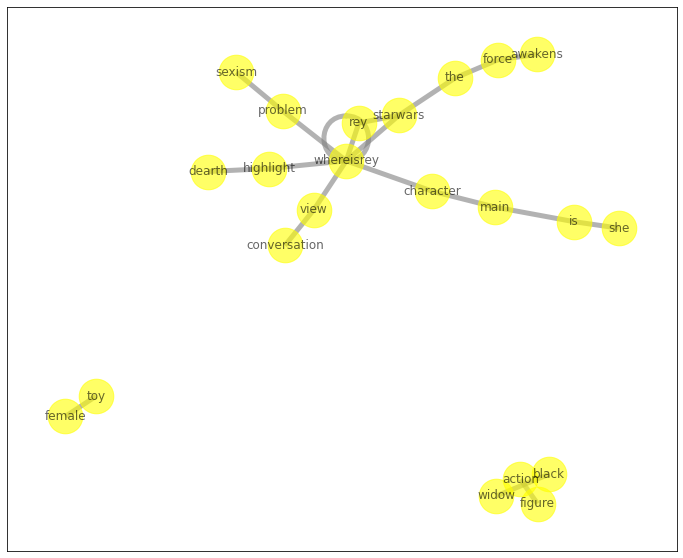

In [10]:
fig, ax = plt.subplots(figsize=(12, 10))

pos = nx.spring_layout(G, k=3)

# Plot networks
nx.draw_networkx(G, pos,
                 font_size=12,
                 width=5,
                 edge_color='grey',
                 node_color='yellow',
                 with_labels = True,
                 alpha=0.6, 
                 node_size = 1200,
                 ax=ax)
    
plt.show()

### Topic Modeling Approaches
Topic modeling aims to find distinct groupings of terms, with each group belonging to the same topic. There are multiple ways you can do topic modeling. We will start with the cluster analysis first.

##### Topic Modeling via Cluster Analysis of Terms
We use two types of cluster analysis in this session. Hierarchical cluster analysis(HCA) and K-means cluster analysis.

In [11]:
# we set max_features = 30 to show the first 30 most frequent terms
max_terms = 30
vectorizer = CountVectorizer(max_features=max_terms, stop_words='english', lowercase = True)
x = vectorizer.fit_transform(processed_posts)
terms = vectorizer.get_feature_names_out()

In [12]:
dt = pd.DataFrame(x.toarray().transpose(), index = vectorizer.get_feature_names_out() )
# removeSparseTerms, to remove 95% of sparse, here we keep terms that appear on at lest 5% of ducuments
dt = dt[dt.sum(axis=1) >= math.floor(0.05*dt.shape[1])]
dist = pdist(dt)

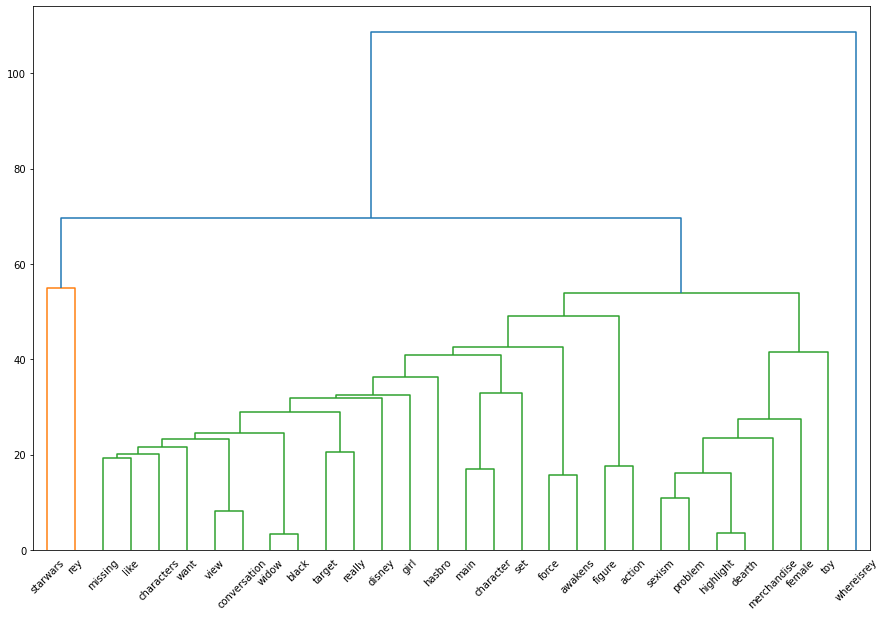

In [13]:
# These are routines for agglomerative clustering.
# single(y):       Perform single/min/nearest linkage on the condensed distance matrix y.
# complete(y):     Perform complete/max/farthest point linkage on a condensed distance matrix.
# average(y):      Perform average/UPGMA linkage on a condensed distance matrix.
# weighted(y):     Perform weighted/WPGMA linkage on the condensed distance matrix.
# centroid(y):     Perform centroid/UPGMC linkage.
# median(y):       Perform median/WPGMC linkage.
# ward(y):         Perform Ward’s linkage on a condensed distance matrix.

matrix = ward(dist) 
fig, ax = plt.subplots(figsize=(15, 10)) # set size
ax = dendrogram(matrix, orientation="top", distance_sort='descending',show_leaf_counts=True, labels=terms,color_threshold=60)

plt.show()

#uncomment below to save figure
#plt.savefig('ward_clusters.png')

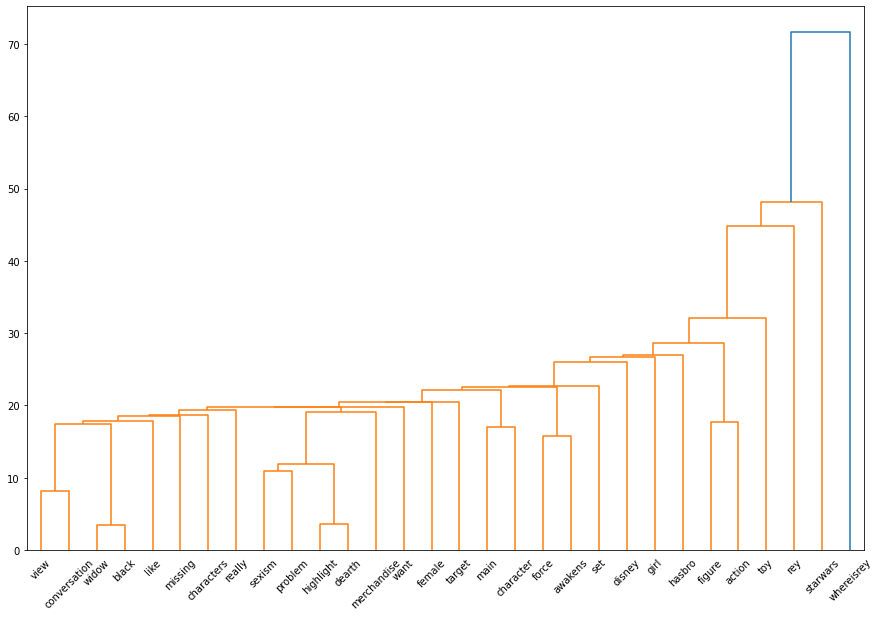

In [14]:
# These are routines for agglomerative clustering.
# single(y):       Perform single/min/nearest linkage on the condensed distance matrix y.
# complete(y):     Perform complete/max/farthest point linkage on a condensed distance matrix.
# average(y):      Perform average/UPGMA linkage on a condensed distance matrix.
# weighted(y):     Perform weighted/WPGMA linkage on the condensed distance matrix.
# centroid(y):     Perform centroid/UPGMC linkage.
# median(y):       Perform median/WPGMC linkage.
# ward(y):         Perform Ward’s linkage on a condensed distance matrix.

matrix = single(dist) 
fig, ax = plt.subplots(figsize=(15, 10)) # set size
ax = dendrogram(matrix, orientation="top", distance_sort='descending',show_leaf_counts=True, labels=terms)

plt.show()

#uncomment below to save figure
#plt.savefig('single_clusters.png')

##### K-means Clsutering
K-Means Clustering, or KMC, aims to group data based on a pre-determined number of clusters K.

In [15]:
#pip install threadpoolctl --upgrade

In [16]:
num_clusters = 6
km = KMeans(n_clusters=num_clusters)
km.fit(dt)
clusters = km.labels_.tolist()

C:\Users\13193\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\13193\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [17]:
# show terms and clusters
clu = pd.DataFrame(list(zip(terms, clusters)), columns=['term', 'cluster'])
clu

,term,cluster
0,action,3
1,awakens,2
2,black,2
3,character,2
4,characters,2
5,conversation,2
6,dearth,0
7,disney,2
8,female,0
9,figure,3


In [18]:
# to find centers
km.cluster_centers_

array([[ 2.85714286e-01,  1.42857143e-01,  1.38777878e-17, ...,
         2.85714286e-01,  5.55111512e-17,  1.42857143e-01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         1.00000000e+00,  1.00000000e+00,  0.00000000e+00],
       [ 1.66666667e-01,  1.66666667e-01,  5.55555556e-02, ...,
        -2.77555756e-17,  3.33333333e-01,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00, ...,
         2.00000000e+00,  2.00000000e+00,  1.00000000e+00],
       [ 1.00000000e+00,  0.00000000e+00,  1.00000000e+00, ...,
         1.00000000e+00,  1.00000000e+00,  2.00000000e+00]])

For more information about k-means in python: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

## Topic Modeling with Latent Dirichlet allocation (LDA)
Latent Dirichlet allocation (LDA) is one of the most common algorithms for topic modeling. Without diving into the math behind the model, we can understand it as being guided by two principles.
\ Every document is a mixture of topics. We imagine that each document may contain words from several topics in particular proportions. For example, in a two-topic model we could say “Document 1 is 90% topic A and 10% topic B, while Document 2 is 30% topic A and 70% topic B.”
\ Every topic is a mixture of words. For example, we could imagine a two-topic model of American news, with one topic for “politics” and one for “entertainment.” The most common words in the politics topic might be “President”, “Congress”, and “government”, while the entertainment topic may be made up of words such as “movies”, “television”, and “actor”. Importantly, words can be shared between topics; a word like “budget” might appear in both equally.
\ More formally, LDA is a mathematical method for estimating both of these at the same time: finding the mixture of words that is associated with each topic, while also determining the mixture of topics that describes each document. There are a number of existing implementations of this algorithm, and we’ll explore one of them (Gibbs Sampling) in depth.
\ LDA is an important technique for topic modeling. It uses Baysian methods to derive the term-term relationships. It has commonly used nowadays for text corpus understanding and evolvement.
\ To run a LDA method on the Rey corpus, we will use the following codes:

##### Define a customized text processing function for LDA

In [20]:
def LDAPreprocessing(text): 
    # get lowercase
    text = text.lower()
    # remove numbers    # remove numbers

    text = re.sub(r'\d+', '', text)
    # remove urls
    text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text)
    # remove punctuation
    text = text.translate(text.maketrans('', '', string.punctuation))
    # strip whitespace
    text = text.strip()
    # remove stop words
    stop_words = stopwords.words('english')
    newStopWords = ['html','yet']
    stop_words.extend(newStopWords)
    stop_words = set(stop_words)
    tokens = word_tokenize(text)
    words = [w for w in tokens if not w in stop_words]
    text = " ".join(w for w in words)
    text = text.replace('theforceawakens', 'the force awakens')
    text = text.replace('merchsexismproblem', 'merch sexism problem')
    text = text.replace('merchsexismproblem', 'merch sexism problem')
    text = text.replace('highlightsdearthfemaletoyhtml', 'highlights dearth female toy')
    text = text.replace('highlightsdearthinfemaletoyhtml', 'highlights dearth in female toy')
    text = text.replace('merchandise', 'merch')
    text = text.replace('merchs', 'merch')
    text = text.replace('merch', 'merchandise')
    text = text.replace('forceawakens', 'force awakens')
    text = text.replace('arewereallygoingtostart', 'are we really going to start')
    text = text.replace('makers', 'maker')
    text = text.replace('highlights', 'highlight')
    text = text.replace('thisway', 'this way')
    text = text.replace('figures', 'figure')
    text = text.replace('shes', 'she is')

    return text

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    # Initialize spacy 'en' model, keeping only tagger component (for efficiency)
    nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [21]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

In [1]:
posts = ReyPosts.Posts.values
# preprocess posts
processed_posts = [ReyPreprocessing(text) for text in posts]
posts_words = list(sent_to_words(processed_posts))
print(posts_words[0])

NameError: name 'ReyPosts' is not defined

In [23]:
# Do lemmatization keeping only noun, adj, vb, adv
posts_lemmatized = lemmatization(posts_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
print(posts_lemmatized[0])

['exclusively', 'release', 'starwar', 'toy', 'set', 'female', 'character']


The two main inputs to the LDA topic model are the dictionary(id2word) and the corpus. Gensim creates a unique id for each word in the document. The produced corpus shown below is a mapping of (word_id, word_frequency).

In [24]:
# Create Dictionary
id2word = corpora.Dictionary(posts_lemmatized)
# Create Corpus
texts = posts_lemmatized
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[0])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1)]


### Base Model
Now we can train the base LDA model. In addition to the corpus and dictionary, you can set the number of topics as well. Apart from that, alpha and eta are hyperparameters that affect sparsity of the topics, both defaults to 1.0/num_topics prior.

In [25]:
# Build LDA model
# chunksize (int, optional) – Number of documents to be used in each training chunk.
# passes (int, optional) – Number of passes through the corpus during training.

lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=6, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

In [26]:
# Print the Keyword in the 10 topics
print(lda_model.print_topics())

[(0, '0.097*"whereisrey" + 0.051*"starwar" + 0.036*"female" + 0.033*"toy" + 0.025*"merchandise" + 0.025*"figure" + 0.023*"highlight" + 0.023*"action" + 0.023*"sexism" + 0.022*"problem"'), (1, '0.068*"whereisrey" + 0.037*"character" + 0.033*"starwar" + 0.019*"female" + 0.018*"woman" + 0.017*"new" + 0.016*"force" + 0.016*"main" + 0.014*"figure" + 0.013*"hasbro"'), (2, '0.069*"whereisrey" + 0.059*"girl" + 0.035*"boy" + 0.021*"want" + 0.020*"play" + 0.018*"toy" + 0.016*"starwar" + 0.014*"come" + 0.014*"character" + 0.014*"target"'), (3, '0.110*"starwar" + 0.083*"whereisrey" + 0.068*"force" + 0.050*"awaken" + 0.021*"hasbro" + 0.020*"figure" + 0.012*"set" + 0.012*"action" + 0.011*"old" + 0.011*"year"'), (4, '0.133*"whereisrey" + 0.023*"character" + 0.022*"figure" + 0.019*"disney" + 0.018*"find" + 0.017*"starwar" + 0.017*"toy" + 0.017*"include" + 0.016*"action" + 0.016*"set"'), (5, '0.093*"whereisrey" + 0.058*"set" + 0.045*"starwar" + 0.043*"character" + 0.036*"main" + 0.025*"s" + 0.024*"targ

In [27]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=posts_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.29028207068087114


## Hyperparameter Tuning and Model Evaluation (This step is very time consuming)

In [28]:
# put previous process into a function
def compute_coherence_values(corpus, id2word, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b,
                                           per_word_topics=True)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=posts_lemmatized, dictionary=id2word, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

we can set different topics and hyperparameters, you can alwasy try a wider selection of hyperparameters

In [29]:
# Topics range
min_topics = 4
max_topics = 10
step_size = 1
topics_range = range(min_topics, max_topics, step_size)
# Alpha parameter
# this will set alpha select from (0.01, 0.31, 0.61, 0.91)
# alpha = list(np.arange(0.01, 1, 0.3))
alpha = list(np.arange(0.01, 1, 0.5))
alpha.append('symmetric')
# Beta parameter
# this will set beta select from (0.01, 0.31, 0.61, 0.91)
# beta = list(np.arange(0.01, 1, 0.3))
beta = list(np.arange(0.01, 1, 0.5))
beta.append('symmetric')

num_of_docs = len(corpus)
model_results = {'Topics': [], 'Alpha': [],'Beta': [],'Coherence': []}

Then we run different models with each pares of topics and hyperparameters and show coherence scores

In [30]:
%%time 
# Can take a long time to run

# iterate through number of topics
for k in topics_range:
    # iterate through alpha values
    for a in alpha:
        # iterare through beta values
        for b in beta:
            # get the coherence score for the given parameters
            cv = compute_coherence_values(corpus=corpus, id2word=id2word, 
                                          k=k, a=a, b=b)
            # Save the model results
            model_results['Topics'].append(k)
            model_results['Alpha'].append(a)
            model_results['Beta'].append(b)
            model_results['Coherence'].append(cv)

results_df = pd.DataFrame(model_results)

Wall time: 18min 11s


In [31]:
print(results_df)

    Topics      Alpha       Beta  Coherence
0        4       0.01       0.01   0.293167
1        4       0.01       0.51   0.287006
2        4       0.01  symmetric   0.283812
3        4       0.51       0.01   0.287137
4        4       0.51       0.51   0.269134
5        4       0.51  symmetric   0.295721
6        4  symmetric       0.01   0.295625
7        4  symmetric       0.51   0.267903
8        4  symmetric  symmetric   0.282641
9        5       0.01       0.01   0.274414
10       5       0.01       0.51   0.276810
11       5       0.01  symmetric   0.274235
12       5       0.51       0.01   0.276323
13       5       0.51       0.51   0.275683
14       5       0.51  symmetric   0.255900
15       5  symmetric       0.01   0.276404
16       5  symmetric       0.51   0.282500
17       5  symmetric  symmetric   0.277862
18       6       0.01       0.01   0.281191
19       6       0.01       0.51   0.303119
20       6       0.01  symmetric   0.280955
21       6       0.51       0.01

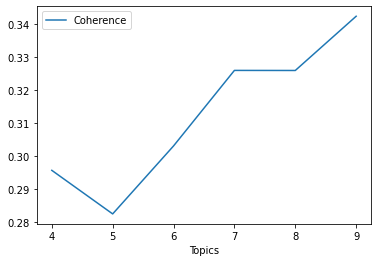

In [32]:
# for each topic, find the maximum coherence score and plot
ax = results_df.groupby(['Topics'], as_index=False)['Coherence'].max().plot(x='Topics', y='Coherence', rot=0)

We know from the above graph that number of topics = 9 possibly gives us the highest coherence score. We can then find the best hyperparameters using the table below. You can change number of topics below to any number to see the results. Upon further examination on the visualization outputs, it turns out that 7 is the best number with minimal topic overlap.

In [33]:
results_df[results_df['Topics'] == 9 ].sort_values(by='Coherence', ascending=False)

,Topics,Alpha,Beta,Coherence
49,9,0.51,0.51,0.342461
52,9,symmetric,0.51,0.326418
48,9,0.51,0.01,0.319494
53,9,symmetric,symmetric,0.312781
50,9,0.51,symmetric,0.309719
51,9,symmetric,0.01,0.301174
45,9,0.01,0.01,0.296528
46,9,0.01,0.51,0.291367
47,9,0.01,symmetric,0.275296


In [34]:
results_df[results_df['Topics'] == 7 ].sort_values(by='Coherence', ascending=False)

,Topics,Alpha,Beta,Coherence
34,7,symmetric,0.51,0.326032
28,7,0.01,0.51,0.322996
31,7,0.51,0.51,0.310786
29,7,0.01,symmetric,0.298032
35,7,symmetric,symmetric,0.294916
33,7,symmetric,0.01,0.274411
27,7,0.01,0.01,0.273463
30,7,0.51,0.01,0.271651
32,7,0.51,symmetric,0.271364


## Final Model
Now we rerun our final model with best hyperparameters. We will do number of topics = 9 first.

In [35]:
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=9, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=0.51,
                                           eta=0.51)


In [36]:
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6      0.189564 -0.012332       1        1  18.806840
0     -0.011722  0.153691       2        1  17.291061
4      0.019780  0.076211       3        1  13.164251
5      0.070932 -0.027118       4        1  12.207737
3      0.048404 -0.083361       5        1  11.716965
2     -0.088327 -0.023988       6        1   7.891498
8     -0.069678 -0.012302       7        1   6.850909
7     -0.081613 -0.032461       8        1   6.344930
1     -0.077339 -0.038339       9        1   5.725809, topic_info=         Term        Freq       Total Category  logprob  loglift
4         set  320.000000  320.000000  Default  30.0000  30.0000
5     starwar  849.000000  849.000000  Default  29.0000  29.0000
26      force  231.000000  231.000000  Default  28.0000  28.0000
189    figure  324.000000  324.000000  Default  27.0000  27.0000
188    action  260.000000  260.000000  Default  26.0000  26.0000
...       ...         ...         ...      ...      ...      ...
1468  brother    3.270813    9.569688   Topic9  -6.0665   1.7866
5     starwar    6.726836  849.858647   Topic9  -5.3455  -1.9788
25     disney    4.634171  104.967212   Topic9  -5.7181  -0.2600
62      story    3.636228   19.528996   Topic9  -5.9606   1.1792
39     hasbro    3.839484  194.578547   Topic9  -5.9062  -1.0653

[474 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
1346      4  0.509456      abcnew
325       7  0.710686  absolutely
2416      6  0.495334    absurdly
1997      6  0.606142      accion
188       1  0.007690      action
...     ...       ...         ...
528       5  0.377865        year
528       7  0.314887        year
528       8  0.031489        year
528       9  0.031489        year
751       2  0.631377       young

[1222 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 1, 5, 6, 4, 3, 9, 8, 2])

Now we do number of topics = 7

In [37]:
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=7, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha='symmetric',
                                           eta=0.51)

In [38]:
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.142445  0.017133       1        1  25.442229
0     -0.007928  0.114551       2        1  22.803900
3     -0.031909 -0.026068       3        1  15.207522
4     -0.005835  0.033340       4        1  14.449566
5     -0.041236 -0.122439       5        1  12.093374
2      0.107365  0.022047       6        1   6.121098
1      0.121989 -0.038565       7        1   3.882312, topic_info=        Term        Freq       Total Category  logprob  loglift
26     force  249.000000  249.000000  Default  30.0000  30.0000
4        set  331.000000  331.000000  Default  29.0000  29.0000
22    awaken  165.000000  165.000000  Default  28.0000  28.0000
5    starwar  919.000000  919.000000  Default  27.0000  27.0000
188   action  298.000000  298.000000  Default  26.0000  26.0000
..       ...         ...         ...      ...      ...      ...
26     force    3.107384  249.305767   Topic7  -5.7292  -1.1362
17      even    2.462742   71.070263   Topic7  -5.9617  -0.1137
33      miss    2.461747  100.725212   Topic7  -5.9622  -0.4628
60       new    2.344803   61.029437   Topic7  -6.0108  -0.0104
189   figure    2.455189  371.494288   Topic7  -5.9648  -1.7706

[427 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
1346      5  0.559481  abcnew
188       1  0.067110  action
188       2  0.818742  action
188       3  0.006711  action
188       4  0.090598  action
...     ...       ...     ...
452       3  0.127449   wrong
452       4  0.573518   wrong
452       6  0.063724   wrong
195       2  0.644643     xwe
2171      7  0.285112    yawn

[910 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 1, 4, 5, 6, 3, 2])

LDA package offers much more capabilities. It can also be used in conjunction with other packages for advanced analytics and visualizations. See: https://radimrehurek.com/gensim/models/ldamulticore.html

You can also learn more about evaluating topic models https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0

Watch https://m.youtube.com/watch?feature=youtu.be&v=T05t-SqKArY. A very good video to help you understand the parameters in LDA